In [1]:
import numpy as np
import scipy as sp
import json
from PIL import Image #pip install Pillow
from matplotlib import pyplot as plt
#from scipy.misc import imread


#reference
#https://www.kaggle.com/code/yassineghouzam/introduction-to-cnn-keras-0-997-top-6


**This is to train CNN model**

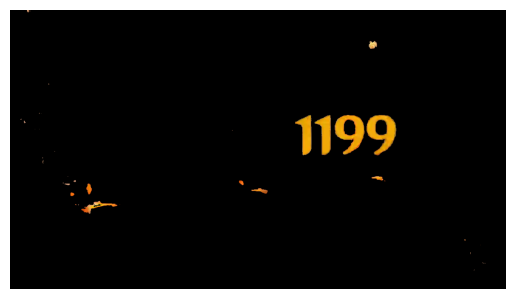

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load the image
image_path = 'img/train/frame4.jpg'  # 'img/train/frame4.jpg' 'img/test/frame56.jpg'
image = cv2.imread(image_path)

# Convert the image to HSV color space
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define the range for detecting orange color in the image
lower_orange = np.array([10, 100, 100])  # Start of orange hue
upper_orange = np.array([25, 255, 255])  # End of orange hue

# Create a mask to isolate orange areas in the image
orange_mask = cv2.inRange(hsv_image, lower_orange, upper_orange)

# Apply the mask on the original image to show orange areas only
orange_only = cv2.bitwise_and(image, image, mask=orange_mask)

# Display the result
plt.imshow(cv2.cvtColor(orange_only, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


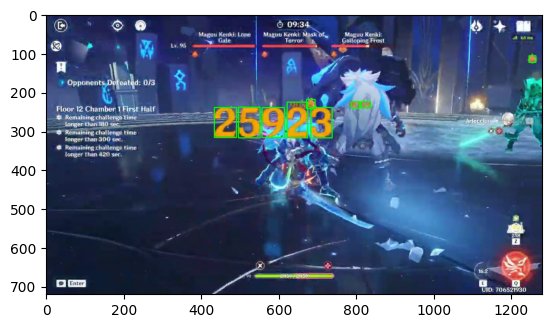

In [3]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load the image
image_path = 'img/test/frame29.jpg' 
image = cv2.imread(image_path)

# Convert the image to HSV color space
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define the range for detecting orange color in the image
lower_orange = np.array([10, 100, 100])  # Start of orange hue
upper_orange = np.array([25, 255, 255])  # End of orange hue

# Create a mask to isolate orange areas in the image
orange_mask = cv2.inRange(hsv_image, lower_orange, upper_orange)

# Apply the mask on the original image to show orange areas only
orange_only = cv2.bitwise_and(image, image, mask=orange_mask)

# Convert the result to grayscale for digit recognition
gray_orange_only = cv2.cvtColor(orange_only, cv2.COLOR_BGR2GRAY)

# Optional: Apply thresholding to enhance the red digits
_, thresh = cv2.threshold(gray_orange_only, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Detect contours in the thresholded image (to focus on digit areas)
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw bounding boxes around contours that are likely digits
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    if h > 15:  # Filter based on height (adjust as needed for your image size)
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)

# Display the result
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()


In [4]:
TRAIN_PATH = 'img/test/'
TRAIN_DIGITSTRUCT = 'img/test/train_ds.json'
DIGIT_RATIO = 24./32

In [5]:
with open(TRAIN_DIGITSTRUCT, 'r') as f:
    train_ds = json.load(f)
print(len(train_ds))
print(len(train_ds['files']))



1
7


In [6]:

sample = train_ds['files'][1]
sample

{'filename': 'frame32.jpg',
 'boxes': [{'height': 33.333333333333314,
   'label': 1.0,
   'left': 483.8596491228071,
   'top': 263.9473684210526,
   'width': 16.66666666666663},
  {'height': 35.96491228070175,
   'label': 9.0,
   'left': 504.0350877192983,
   'top': 263.9473684210526,
   'width': 22.80701754385973},
  {'height': 32.456140350877206,
   'label': 8.0,
   'left': 529.4736842105264,
   'top': 267.45614035087715,
   'width': 18.42105263157896},
  {'height': 28.070175438596493,
   'label': 9.0,
   'left': 552.2807017543861,
   'top': 267.45614035087715,
   'width': 21.052631578947285},
  {'height': 35.087719298245645,
   'label': 1.0,
   'left': 576.842105263158,
   'top': 265.7017543859649,
   'width': 18.421052631578846}]}

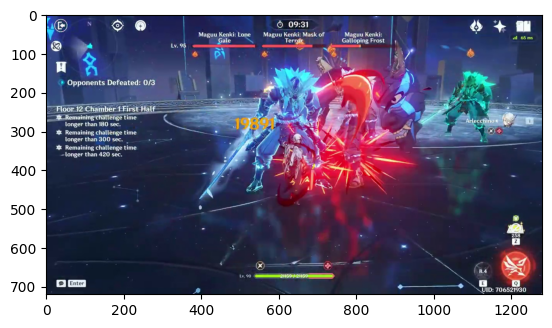

In [7]:
im = np.array(Image.open(TRAIN_PATH + sample['filename']))
plt.imshow(im)

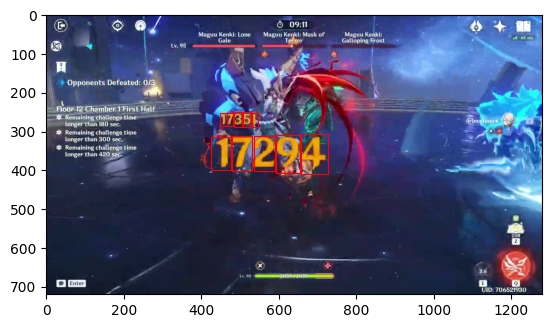

In [8]:
sample = train_ds['files'][2]
im = np.array(Image.open(TRAIN_PATH + sample['filename']))
plt.imshow(im)

boxes = sample['boxes']
for box in boxes:
    rect = plt.Rectangle((box['left'], box['top']), box['width'], box['height'], 
                         linewidth=0.8, edgecolor='red', facecolor='none')
    plt.gca().add_patch(rect)
plt.show()

In [9]:

def preprocess(img):
    try:
        img = np.array(Image.fromarray(img).resize((32, 24)))
        #img = imresize(img, (32, 24))
        img = img.astype(np.float32) / np.max(img)
    except:
        return None
    return img

def gen_cuts(image, boxes):
    cuts = []
    labels = []
    
    number_left = image.shape[1]
    number_right = 0
    number_top = image.shape[0]
    number_bottom = 0
    
    na_w = 0
    na_h = 0
    
    for box in boxes:
        middle = int(box['left'] + box['width'] / 2)
        height = int(box['height'])
        width = int(height * DIGIT_RATIO)
        left = int(middle - width/2)
        right = left + width
        top = int(box['top'])
        bottom = top + height
        
        if left < number_left: number_left = left
        if right > number_right: number_right = right
        if top < number_top: number_top = top
        if bottom > number_bottom: number_bottom = bottom
        if na_w == 0: na_w = width
        if na_h == 0: na_h = height
        
        cut = im[top:bottom, left:right]
        cut = preprocess(cut)
        
        if cut is None:
            continue
        
        cuts.append(cut)
        label = box['label'] if box['label'] != 10 else 0
        labels.append(int(label))
    
    for left in range(0, image.shape[1]-na_w, na_w):
        if (left+na_w < number_left) or (left > number_right):
            cut = im[0:na_h, left:left+na_w]
            cut = preprocess(cut)

            if cut is None:
                continue
            cuts.append(cut)
            labels.append(10)
    

    return cuts, labels


In [10]:
all_cuts = []
all_labels = []
for i, sample in enumerate(train_ds['files']):
    if i % 1000 == 0: print(i)

    im = np.array(Image.open(TRAIN_PATH + sample['filename']).convert('L'))
    img_cuts, img_labels = gen_cuts(im, sample['boxes'])
    all_cuts.extend(img_cuts)
    all_labels.extend(img_labels)

print("{} cuts total".format(len(all_labels)))
print('done!')

0
207 cuts total
done!


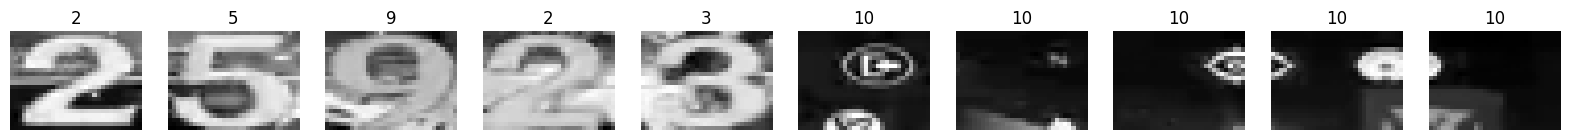

In [11]:
plt.rcParams['figure.figsize'] = (20.0, 20.0)
f, ax = plt.subplots(nrows=1, ncols=10)

for i, cut in enumerate(all_cuts[:10]):
    ax[i].axis('off')
    ax[i].imshow(cut, cmap='gray')
    ax[i].set_title(all_labels[i], loc='center')

In [12]:
import json
import cv2
import numpy as np
import os

# Load the merged JSON file
with open('img/test/train_ds.json', 'r') as f:
    train_ds = json.load(f)

# Function to crop and preprocess the digit images
def preprocess_data(train_ds, base_path):
    images = []
    labels = []

    # Define the orange color range in HSV space
    lower_orange = np.array([10, 100, 100])
    upper_orange = np.array([25, 255, 255])
    
    for item in train_ds['files']:
        img_path = os.path.join(base_path, item['filename'])
        #img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.imread(img_path)

        # Convert the image to HSV color space
        hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        
        # Create a mask to isolate orange areas in the image
        orange_mask = cv2.inRange(hsv_img, lower_orange, upper_orange)
        
        # Apply the mask to get the orange regions
        orange_regions = cv2.bitwise_and(img, img, mask=orange_mask)
        
        for box in item['boxes']:
            left = int(box['left'])
            top = int(box['top'])
            width = int(box['width'])
            height = int(box['height'])
            label = int(box['label'])
            
            # Ensure the label is within the expected range
            if 0 <= label <= 9:
                # Crop the image
                cropped_img = orange_regions[top:top + height, left:left + width]
                resized_img = cv2.resize(cropped_img, (28, 28))  # Resize to 28x28 pixels

                # Convert to grayscale since model input may require it
                gray_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)

                images.append(gray_img)
                labels.append(label)
    
    images = np.array(images).reshape(-1, 28, 28, 1)  # Reshape for model input
    labels = np.array(labels)
    
    return images, labels

# Base path to the images
base_path = 'img/test'
images, labels = preprocess_data(train_ds, base_path)


Number of samples: 42


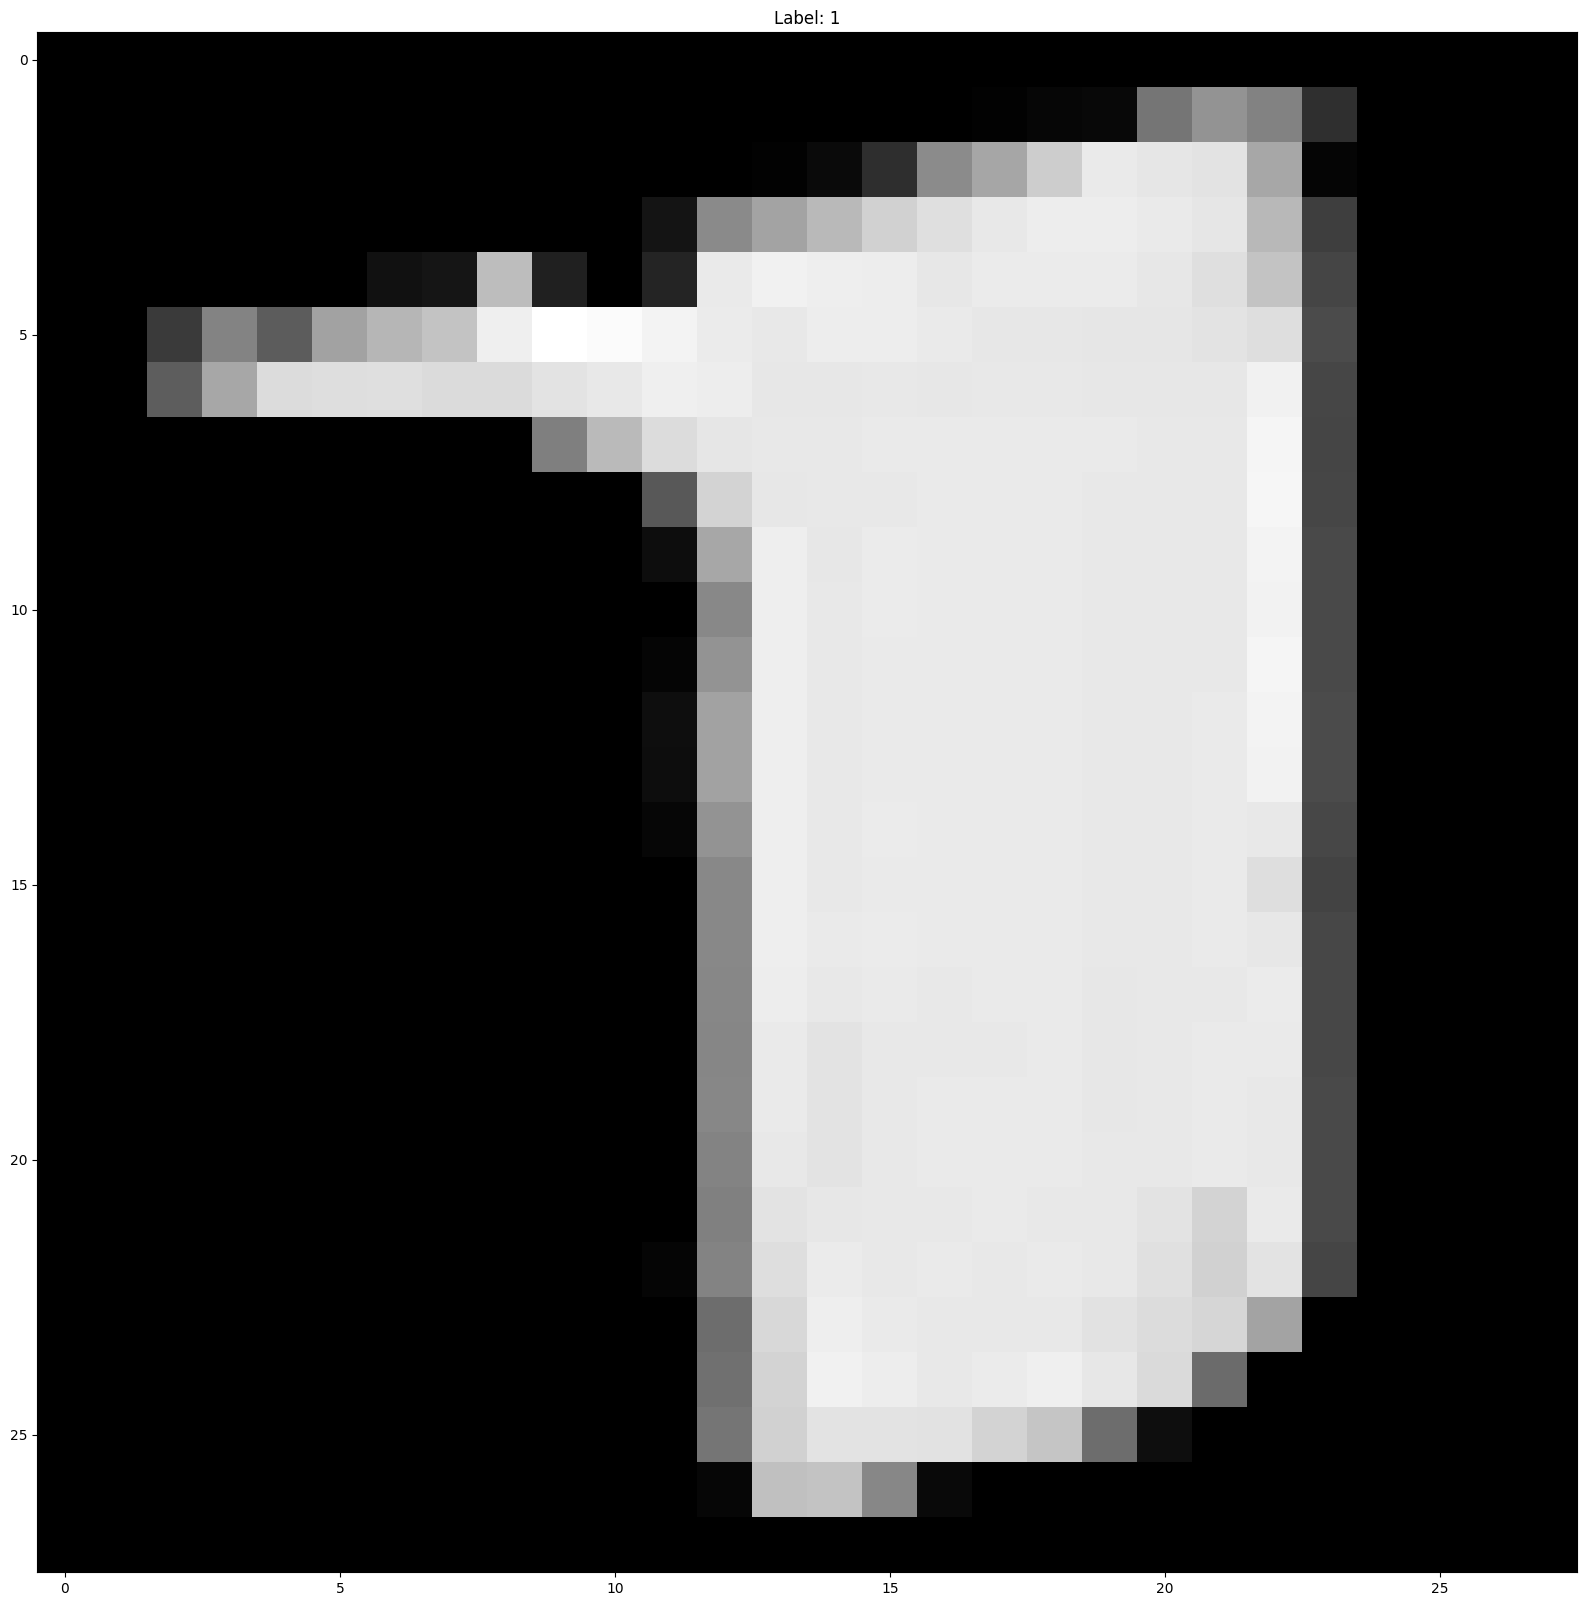

In [13]:
# Print the length of the dataset
print(f"Number of samples: {len(images)}")

# Visualize one of the samples (for example, the first one)
sample_index = 30
sample_image = images[sample_index].reshape(28, 28)  # Reshape for visualization
sample_label = labels[sample_index]

plt.imshow(sample_image, cmap='gray')
plt.title(f"Label: {sample_label}")
plt.show()


Number of samples: 42


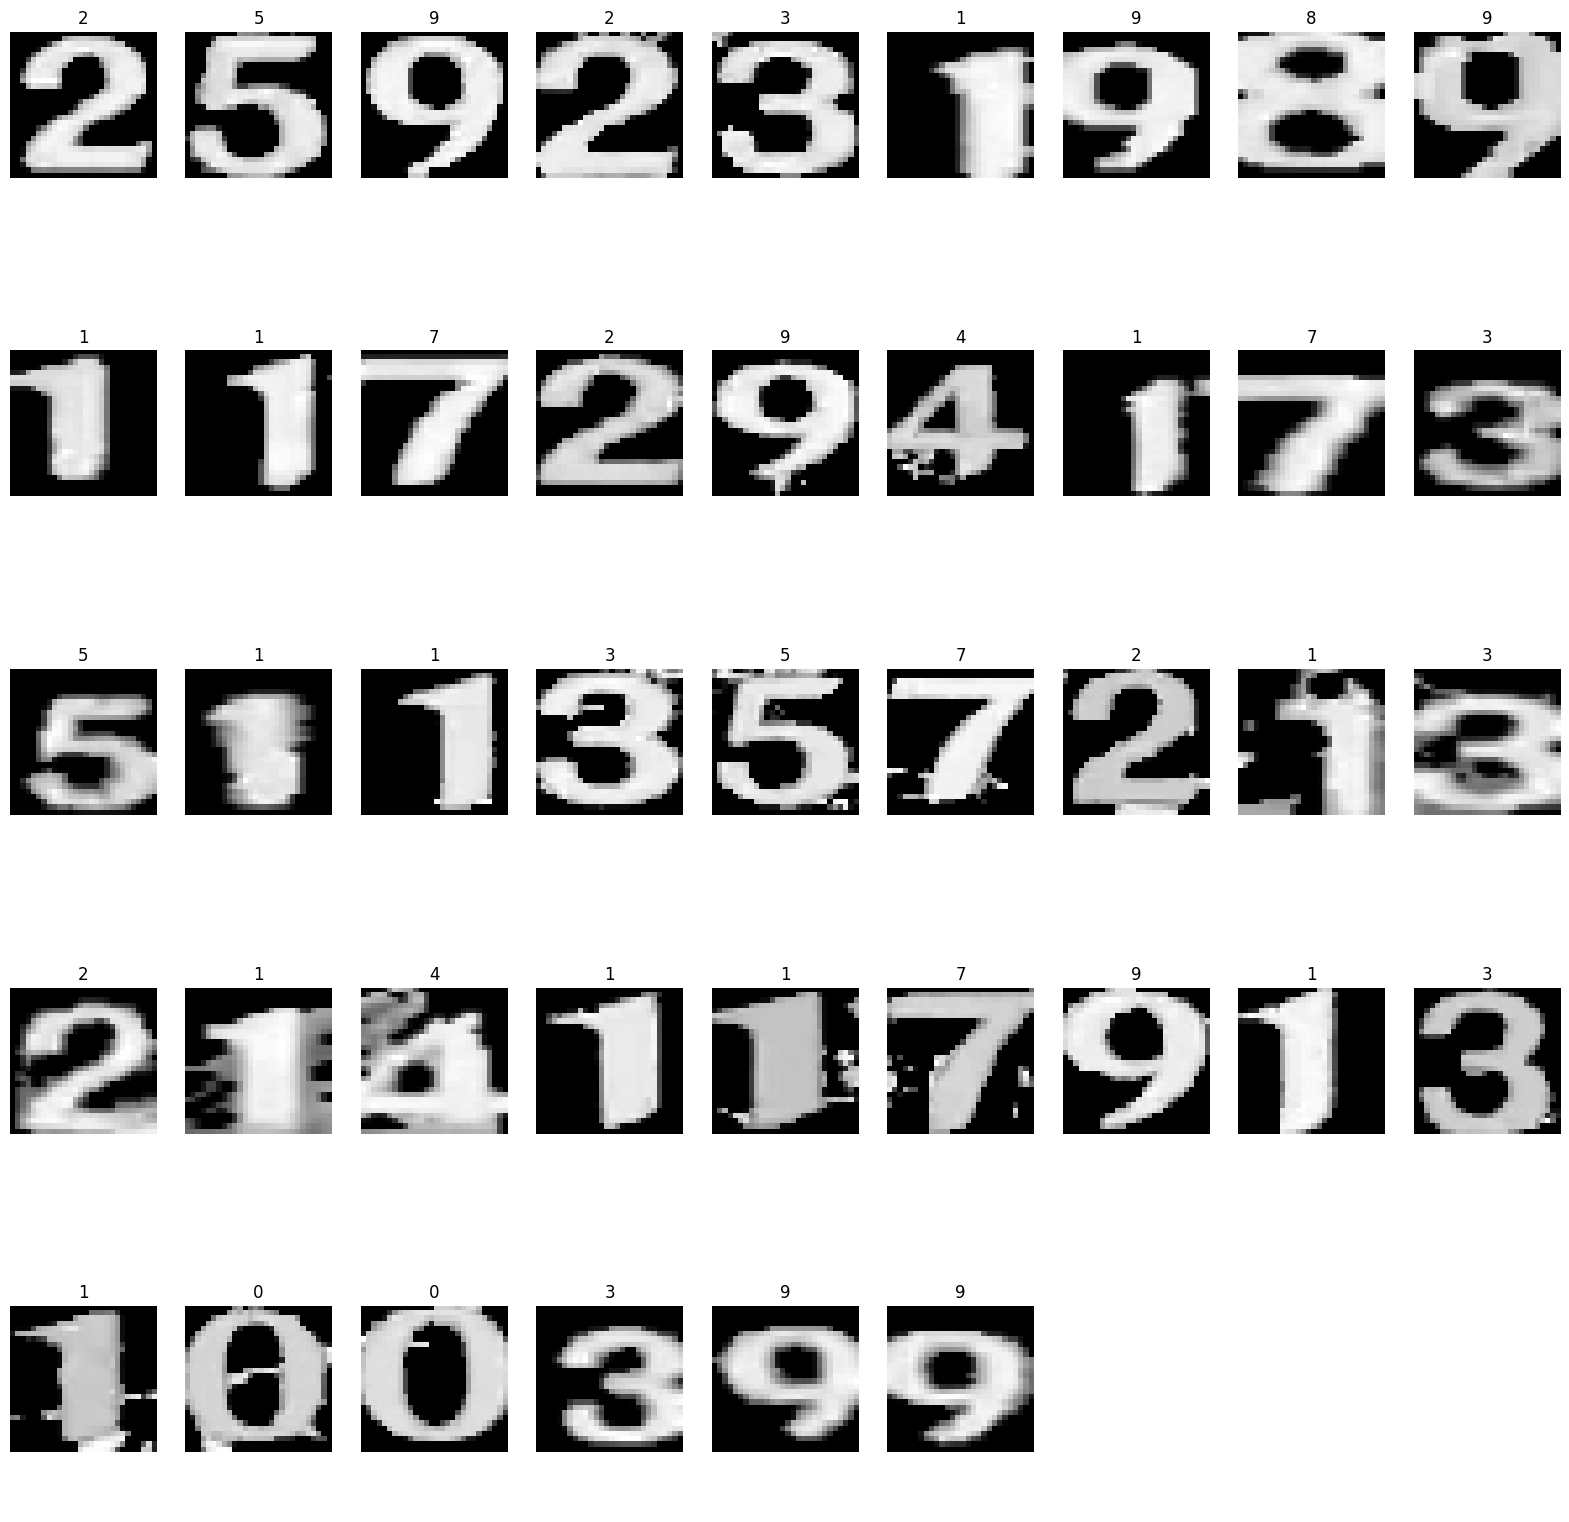

In [14]:
# Print the length of the dataset
print(f"Number of samples: {len(images)}")

# Visualization: Display all samples in a 5x9 grid
plt.rcParams['figure.figsize'] = (20.0, 20.0)
f, ax = plt.subplots(nrows=5, ncols=9)

# Display the first 45 samples (or fewer if less than 45 samples exist)
for i in range(5):
    for j in range(9):
        index = i * 9 + j
        if index < len(images):
            sample_image = images[index].reshape(28, 28)  # Reshape for visualization
            sample_label = labels[index]
            ax[i, j].axis('off')
            ax[i, j].imshow(sample_image, cmap='gray')
            ax[i, j].set_title(sample_label, loc='center')
            #ax[i, j].set_title(int(sample_label), loc='center')
        else:
            ax[i, j].axis('off')  # Hide axis if there are no more samples to display

plt.show()

In [15]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np

# Normalize the images
images = images / 255.0

# One-hot encode the labels
labels = to_categorical(labels, num_classes=10)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)



## Convolutional Neural Networks (CNN) Architecture

### 1. Convolutional (Conv2D) Layers

The first layer in the CNN architecture is the **Convolutional (Conv2D) layer**. It consists of learnable filters that scan across the input image. For my model, I have set **32 filters** for the first two Conv2D layers and **64 filters** for the subsequent two Conv2D layers.

Each filter applies a kernel of a fixed size (e.g., `3x3` or `5x5`) to transform different parts of the image. The kernel slides across the entire image, producing **feature maps**. These feature maps help the CNN isolate features that can be useful across the entire image.

### 2. Max Pooling (MaxPool2D) Layers

The **MaxPooling (MaxPool2D) layer** is responsible for downsampling the feature maps obtained from convolutional layers. It scans a small region (defined by the pooling size) of the feature map and retains the **maximum value** within that region.

MaxPooling reduces the spatial dimensions of the image, which helps decrease computational cost and reduces overfitting to some extent. A larger pooling size results in more significant downsampling.

### 3. Combining Convolution and Pooling Layers

By combining **Convolutional** and **MaxPooling** layers, CNNs are able to learn both local features and global patterns in the image. These layers help extract hierarchical features from the image, making the model more effective at feature detection.

### 4. Dropout Layer

**Dropout** is a regularization method where a portion of the neurons in a layer are randomly ignored during training. This means their weights are set to zero, effectively "dropping" them from the network. This helps the model learn features in a distributed manner, improving generalization and reducing overfitting.

### 5. Activation Function (ReLU)

**ReLU (Rectified Linear Unit)** is the activation function applied to each node's output in the Conv2D layers. The function is defined as `ReLU(x) = max(0, x)`, meaning that it returns `x` if `x` is positive and `0` otherwise. This non-linearity allows the network to learn more complex patterns in the data.

### 6. Flatten Layer

The **Flatten layer** converts the 2D feature maps into a single 1D vector, so that it can be passed into fully connected layers (Dense layers). Flattening combines the local features learned by the convolutional layers into a unified representation.

### 7. Fully Connected (Dense) Layers

After the convolutional and pooling layers, the model passes the data through **fully connected (Dense) layers**, which are standard Artificial Neural Networks (ANN). These layers are used for classification tasks.

- The final Dense layer outputs a probability distribution across all possible classes using the **Softmax** activation function, e.g., `Dense(10, activation="softmax")` for a 10-class classification problem.

### Summary of Layers:
1. **Conv2D Layers**: Apply learnable filters to extract features from the image.
2. **MaxPool2D Layers**: Downsample the feature maps, reducing spatial dimensions.
3. **Dropout**: Regularization technique to prevent overfitting.
4. **ReLU**: Non-linear activation function to enhance learning of complex features.
5. **Flatten Layer**: Converts the 2D feature maps into a 1D vector.
6. **Dense Layers**: Fully connected layers used for classification, ending with a Softmax layer to output probabilities.


In [16]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator


model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',  
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

epochs = 10 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86


c:\Users\ZUHAIR\Desktop\project\damageTracker_project\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Data Augmentation to Avoid Overfitting

In order to address the problem of **overfitting**, we can artificially expand our handwritten digit dataset using **data augmentation** techniques. The idea behind data augmentation is to apply various transformations to the training images, simulating the natural variations that occur when people write digits by hand.

### Examples of Data Variations:
- The digit may not be centered in the image.
- The size of the digit may vary (e.g., some people write large or small numbers).
- The image might be slightly rotated or skewed.

### Data Augmentation Techniques
Data augmentation involves applying transformations that modify the image's array representation while keeping the label the same. Some of the most popular augmentation techniques include:

- **Grayscale**: Converting images to grayscale.
- **Flips**: Horizontal and vertical flips.
- **Random Crops**: Taking random sections of the image.
- **Color Jitters**: Randomly altering brightness, contrast, or saturation.
- **Translations**: Moving the image slightly in any direction.
- **Rotations**: Rotating the image by a small angle.
- **Scaling**: Changing the size of the digits slightly.
- **Shearing**: Skewing the image along the axis.

By applying a few of these transformations, we can significantly increase the size of the training dataset and improve the model's robustness. For instance, we can easily **double or triple** the number of training examples by using these augmentations.

### Impact of Data Augmentation

Data augmentation has a significant impact on the performance of the model. In my experiments:

- **Without data augmentation**, I achieved an accuracy of **33.11%**.
- **With data augmentation**, the accuracy improved to **88.89%**.

This demonstrates that augmenting the training data not only increases the model's robustness but also leads to a substantial improvement in accuracy.


In [17]:
# With data augmentation to prevent overfitting (accuracy 0.8889)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [18]:
# Fit the model
model.fit(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_test,y_test),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/10


c:\Users\ZUHAIR\Desktop\project\damageTracker_project\myenv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 - 2s - 2s/step - accuracy: 0.0909 - loss: 2.3033 - val_accuracy: 0.5556 - val_loss: 2.2642 - learning_rate: 0.0010
Epoch 2/10
1/1 - 0s - 80ms/step - accuracy: 0.3333 - loss: 2.2462 - val_accuracy: 0.3333 - val_loss: 2.2003 - learning_rate: 0.0010
Epoch 3/10
1/1 - 0s - 82ms/step - accuracy: 0.3333 - loss: 2.1345 - val_accuracy: 0.3333 - val_loss: 2.1001 - learning_rate: 0.0010
Epoch 4/10


c:\Users\ZUHAIR\Desktop\project\damageTracker_project\myenv\Lib\site-packages\keras\src\callbacks\callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


1/1 - 0s - 67ms/step - accuracy: 0.1818 - loss: 2.0637 - val_accuracy: 0.3333 - val_loss: 2.0232 - learning_rate: 0.0010
Epoch 5/10
1/1 - 0s - 81ms/step - accuracy: 0.2727 - loss: 2.0723 - val_accuracy: 0.3333 - val_loss: 1.9611 - learning_rate: 0.0010
Epoch 6/10
1/1 - 0s - 81ms/step - accuracy: 0.3333 - loss: 1.9770 - val_accuracy: 0.5556 - val_loss: 1.9157 - learning_rate: 0.0010
Epoch 7/10
1/1 - 0s - 78ms/step - accuracy: 0.4242 - loss: 1.9310 - val_accuracy: 0.5556 - val_loss: 1.8930 - learning_rate: 0.0010
Epoch 8/10
1/1 - 0s - 81ms/step - accuracy: 0.5152 - loss: 1.7957 - val_accuracy: 0.5556 - val_loss: 1.8361 - learning_rate: 0.0010
Epoch 9/10
1/1 - 0s - 67ms/step - accuracy: 0.4545 - loss: 1.8351 - val_accuracy: 0.5556 - val_loss: 1.7359 - learning_rate: 0.0010
Epoch 10/10
1/1 - 0s - 86ms/step - accuracy: 0.4848 - loss: 1.7124 - val_accuracy: 0.5556 - val_loss: 1.5956 - learning_rate: 0.0010


In [19]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')





1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5556 - loss: 1.5956
Test accuracy: 0.5555555820465088


In [20]:
import pickle

# Save the model to a file
model_path = 'models/cnn_model.pkl'
with open(model_path, 'wb') as file:
    pickle.dump(model, file)

print(f"Model saved to {model_path}")

Model saved to models/cnn_model.pkl


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


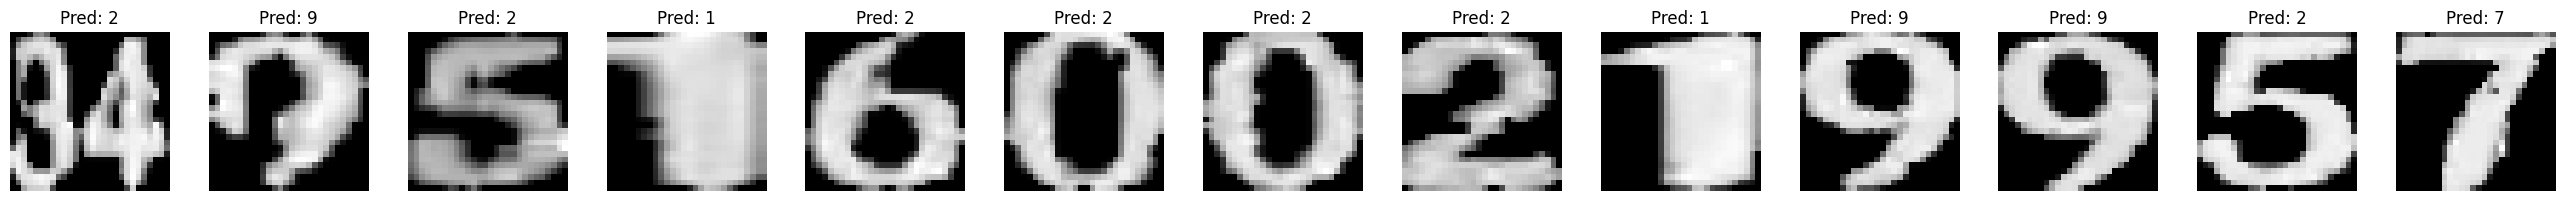

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from PIL import Image

def preprocess_image_with_orange_detection(image_path):

    img = cv2.imread(image_path)
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
  
    lower_orange = np.array([10, 100, 100])
    upper_orange = np.array([25, 255, 255])
    
    orange_mask = cv2.inRange(hsv_img, lower_orange, upper_orange)
    orange_regions = cv2.bitwise_and(img, img, mask=orange_mask)
    
    gray_orange_only = cv2.cvtColor(orange_regions, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray_orange_only, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    digit_images = []
    predictions = []

    # Loop through each contour and detect likely digit areas
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        
        # Apply a filter based on height or width to eliminate small non-digit regions
        if h > 15 and w > 5:  # Adjust thresholds as necessary
            # Crop the detected region
            cropped_img = gray_orange_only[y:y + h, x:x + w]
            
            # Resize the cropped digit to 28x28 pixels (model input size)
            resized_img = cv2.resize(cropped_img, (28, 28))
            
            # Normalize the image
            normalized_img = resized_img / 255.0
            
            # Reshape the image to fit the model's expected input shape (1, 28, 28, 1)
            img_array = np.expand_dims(normalized_img, axis=(0, -1))
            
            # Predict using the model
            prediction = model.predict(img_array)
            predictions.append(np.argmax(prediction, axis=1)[0])
            
            digit_images.append(normalized_img)
    
    return digit_images, predictions

image_path = 'img/train/frame50.jpg' 

# Preprocess the image and detect digits
digit_images, predictions = preprocess_image_with_orange_detection(image_path)

# Plot the detected digits and their predictions in a grid
num_digits = len(digit_images)

# Set up a grid for subplots (1 row, multiple columns based on the number of digits)
fig, axes = plt.subplots(1, num_digits, figsize=(num_digits * 2, 2))  # Adjust the size as necessary

for i, ax in enumerate(axes):
    ax.imshow(digit_images[i], cmap='gray')
    ax.set_title(f'Pred: {predictions[i]}')
    ax.axis('off')  # Hide the axes for clarity

plt.tight_layout()
plt.show()
